In [55]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import scipy.stats as stats

#torch specific
import torch

#other libraries
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

In [56]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

# Predict using resnet

This notebook uses a saved resnet model to predict on test data and generate a confusion matrix. It also saves the wrong predictions for further analysis.

In [57]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
PLOT_ORDER = [0, 2, 1, 3, 5, 4]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT=True

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

ENSEMBLE = True
ENSEMBLE_NAME = "resnet18_1703074946_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
LOAD_FOLDER = f"../results/models/experiment_{ENSEMBLE_NAME}"

#Load ensemble
if ENSEMBLE:
    LOAD_PATHS = [os.path.join(LOAD_FOLDER, f) for f in os.listdir(LOAD_FOLDER) if os.path.isfile(os.path.join(LOAD_FOLDER, f))]
    MODEL_NAMES = [Path(path).stem for path in LOAD_PATHS]
else:
    MODEL_NAMES = ["resnet18_1703078471_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"]
    LOAD_PATHS = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
DEVICE = torch.device("cpu")
ampl.use_atlas_style() 

Running on the GPU


In [58]:
#Load data
testpaths = [Path(path) for path in TEST_DATAPATHS]
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters=[None], transforms=None)

Loads data with transforms None and filters [None]


Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 25613.0859375.
Check max value: 25613.0859375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 40609.1484375.
Check max value: 40609.1484375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 19851.11328125.
Check max value: 19851.11328125.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 23127.8984375.
Check max value: 23127.8984375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 35996.286259531975.
Check max value: 35996.286259531975.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 30371.03125.
Check max value: 30371.03125.
Data has shape torch.Size([50, 50, 3])
There are 6 classes.


In [59]:
model_dfs = [0]*len(LOAD_PATHS)
for i in range(len(LOAD_PATHS)):
    #import model
    model = ResNet18(img_channels=3, num_classes=len(TEST_LABELS))
    model.load_state_dict(torch.load(LOAD_PATHS[i]))
    model.eval()
    model.to(DEVICE)
    truth, preds, confidences = predict(model, test_data, CLASSES, 100, RES, DEVICE, return_conf=True)
    df = pd.DataFrame(dict(zip(["Truth", "Prediction"], [truth, preds])))
    accuracy = accuracy_score(truth, preds, normalize=True)
    df['Confidence'] = torch.max(confidences, dim=-1)[0]
    for j in range(len(LABELS)):
        df[f"{j}"] = confidences[:,j]
    df["index"] = df.index
    correct_list = np.array([True]*len(df))
    correct_list[df["Prediction"] != df["Truth"]] = False
    df["Correct"] = correct_list
    model_dfs[i] = df

Loading model


100%|██████████| 900/900 [00:53<00:00, 16.68it/s]


Loading model


100%|██████████| 900/900 [00:53<00:00, 16.82it/s]


Loading model


100%|██████████| 900/900 [00:54<00:00, 16.59it/s]


Loading model


100%|██████████| 900/900 [00:53<00:00, 16.95it/s]


Loading model


100%|██████████| 900/900 [00:53<00:00, 16.67it/s]


Loading model


100%|██████████| 900/900 [00:53<00:00, 16.78it/s]


Loading model


100%|██████████| 900/900 [00:54<00:00, 16.64it/s]


Loading model


100%|██████████| 900/900 [00:53<00:00, 16.90it/s]


Loading model


100%|██████████| 900/900 [00:53<00:00, 16.75it/s]


Loading model


100%|██████████| 900/900 [00:53<00:00, 16.69it/s]


In [60]:
# Save predictions
for i in range(len(LOAD_PATHS)):
    save_path = f"../results/predictions/resnet/{MODEL_NAMES[i]}.csv"
    model_dfs[i].to_csv(f"{save_path}")

In [61]:
ensemble_df = pd.DataFrame(columns=model_dfs[0].keys())
ensemble_df["Truth"] = model_dfs[0]["Truth"]
ensemble_df["index"] = model_dfs[0]["index"]
ensemble_df["Confidence_avg"] = np.average(np.array([df["Confidence"] for df in model_dfs]), axis=0)
ensemble_df["Prediction_mode"] = stats.mode(np.array([df["Prediction"] for df in model_dfs]), axis=0)[0]
for j in range(len(LABELS)):
    ensemble_df[f"{j}"] = np.average(np.array([df[f"{j}"] for df in model_dfs]), axis=0)
ensemble_df["Prediction"] = ensemble_df[[f"{j}" for j in range(len(LABELS))]].idxmax(axis=1)
ensemble_df["Confidence"] = ensemble_df[[f"{j}" for j in range(len(LABELS))]].max(axis=1)
correct_list = np.array([True]*len(ensemble_df))
correct_list[ensemble_df["Prediction"] != ensemble_df["Truth"]] = False
ensemble_df["Correct"] = correct_list

save_path = f"../results/predictions/resnet/ensemble_{ENSEMBLE_NAME}.csv"
ensemble_df.to_csv(f"{save_path}")

In [62]:
ensemble_df

,Truth,Prediction,Confidence,0,1,2,3,4,5,index,Correct,Confidence_avg,Prediction_mode
0,0.0,0,0.774727,7.747269e-01,0.122297,0.010328,0.051458,9.745822e-04,0.040216,0,False,0.785018,0.0
1,0.0,0,0.981860,9.818600e-01,0.010184,0.003436,0.002748,9.842668e-07,0.001770,1,False,0.981860,0.0
2,0.0,0,0.987130,9.871300e-01,0.008605,0.001564,0.001423,3.792567e-04,0.000899,2,False,0.987130,0.0
3,0.0,0,0.291725,2.917250e-01,0.247327,0.062676,0.176123,7.465195e-02,0.147497,3,False,0.387190,1.0
4,0.0,0,0.661831,6.618312e-01,0.121259,0.080838,0.073087,5.106906e-05,0.062934,4,False,0.661831,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,5.0,1,0.518112,7.586757e-03,0.518112,0.053323,0.233489,6.750912e-04,0.186815,89995,False,0.518112,1.0
89996,5.0,1,0.296561,2.949949e-02,0.296561,0.202159,0.255904,1.175089e-05,0.215865,89996,False,0.347167,1.0
89997,5.0,5,0.284837,7.434266e-05,0.178726,0.279705,0.253920,2.737542e-03,0.284837,89997,False,0.389496,5.0
89998,5.0,3,0.337499,2.775711e-05,0.322722,0.005746,0.337499,2.574748e-02,0.308258,89998,False,0.365477,3.0


[9.454e+01 3.080e+00 2.110e+00 5.000e-02 7.000e-02 1.500e-01 1.002e+01
 7.462e+01 6.990e+00 1.730e+00 5.580e+00 1.070e+00 7.830e+00 6.830e+00
 4.811e+01 8.590e+00 2.111e+01 7.530e+00 4.230e+00 8.410e+00 3.439e+01
 1.047e+01 3.478e+01 7.720e+00 3.230e+00 9.920e+00 2.821e+01 1.058e+01
 4.031e+01 7.750e+00 6.400e-01 7.100e-01 2.950e+00 7.700e-01 2.190e+00
 9.274e+01]
Accuracy: 0.5794111111111111


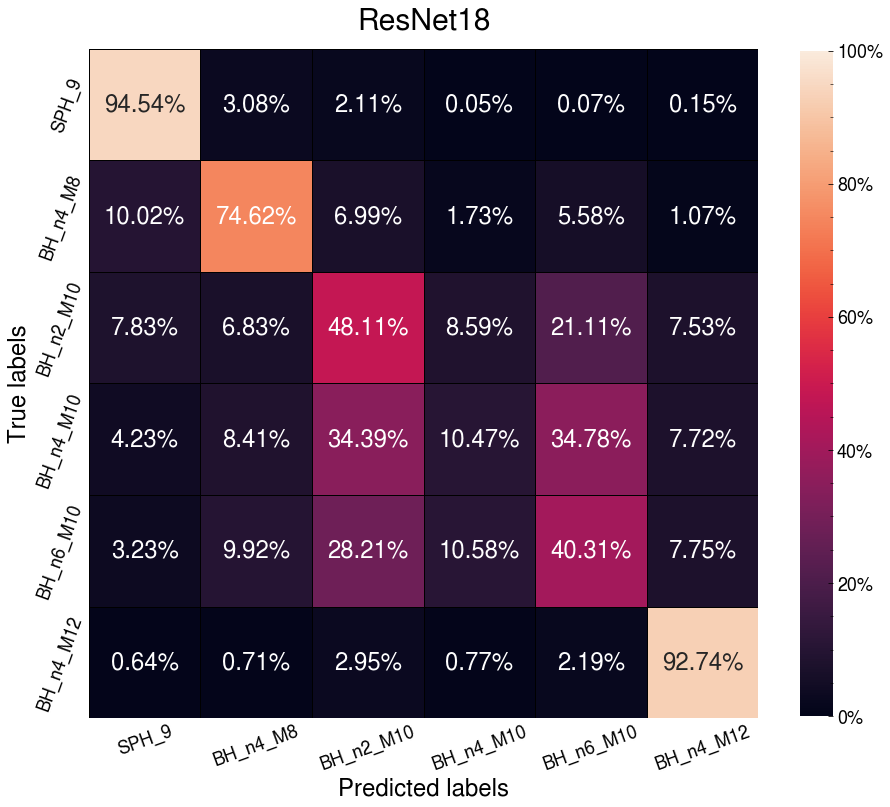

In [63]:
def plot_conf_matrix(df, accuracy, labels, savepath):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(15, 15))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(df["Truth"].astype(int), df["Prediction"].astype(int), normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    cf_matrix = np.array([cf_matrix[i] for i in PLOT_ORDER])
    cf_matrix = np.array([np.array([row[j] for j in PLOT_ORDER]) for row in cf_matrix])
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            vmin=0,
            vmax=100,
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=18, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=18, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18", size=30, pad=20)
    print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    #fig.savefig(f"../results/figures/ResNet18_{TEST_N_EVENTS}_events_CUT_conf_matrix.pdf", format="pdf", bbox_inches='tight')
    fig.savefig(f"{savepath}.pdf", format="pdf", bbox_inches='tight')
    plt.show()
savepath = f"../results/figures/ensemble_ResNet18_{TEST_N_EVENTS}_events_CUT_conf_matrix"
plot_conf_matrix(ensemble_df, accuracy, PLOT_LABELS, savepath)

In [64]:
def save_wrong_predictions(truths, labels, eventids, savepath, filename):
    file = open(f"{savepath}/{filename}.csv", "w")
    file.write(f"Wrongly predicted events from datasets: {testpaths} by model {MODEL_NAME}")
    for i, truth in enumerate(truths):
        file.write(f"{labels[int(truth)]}, {eventids[i]}\n")
    file.close()
    print(f"Saved results to {savepath}/{filename}.csv")
    
filename = f"{MODEL_NAME}_{TEST_N_EVENTS}_events_wrongly_predicted"
#save_wrong_predictions(df_wrong["Truth"].tolist(), PLOT_LABELS, df_wrong["EventID"].tolist(), "../results/", filename)

NameError: name 'MODEL_NAME' is not defined